In [1]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


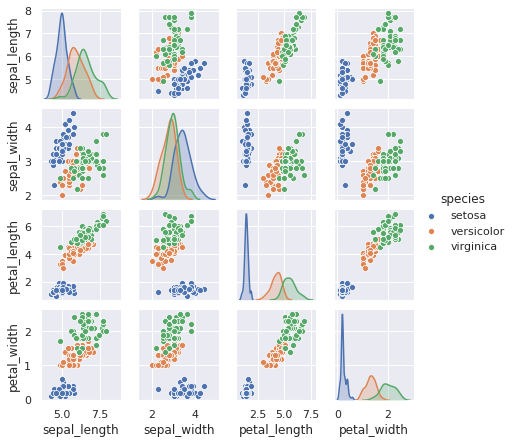

In [2]:
%matplotlib inline
sns.set()
sns.pairplot(iris, hue='species', height=1.5)

In [3]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [4]:
y_iris = iris['species']
y_iris.shape

(150,)

## Использование API scikit-learn

- импорт соответствующего класса estimator из библиотеки
- выбор гиперпараметров, создание экземпляра класса
- компоновка данных в матрицу признаков и вектор целей (scikit-learn поддерживает numpy массивы и в некоторых случаях scypy разреженные матрицы. Массивы pandas придется перегнать в numpy)
- обучение методом fit()
- получение прдсказаний для обучения с учителем через метод predict()
- преобразование для обучения без учителя с методом transform() или предсказание (для кластеризации) методом predict()
- fit() и transform() использются так-же для препроцессинга данных

In [5]:
import matplotlib.pyplot as plt
import numpy as np

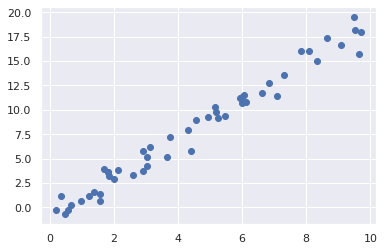

In [6]:
rnd = np.random.RandomState(42)
x = 10 * rnd.rand(50)
y = 2 * x - 1 + rnd.randn(50)
plt.scatter(x, y)

#### Выбор модели

In [7]:
from sklearn.linear_model import LinearRegression

#### Выбор гиперпараметров. Создание экземпляра estimator

подбор точки пересечения с осью координат

In [8]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

#### Подготовка данных


In [9]:
x.shape

(50,)

In [10]:
y.shape

(50,)

In [11]:
X = x[:, np.newaxis]
X.shape

(50, 1)

#### Обучение

In [12]:
model.fit(X, y)

LinearRegression()

In [13]:
model.coef_

array([1.9776566])

In [14]:
model.intercept_

-0.9033107255311164

Это угловой коэфициент и точка пересечения с осью координат для нашей модели.

#### Получение предсказаний

создадим новые данные, которыек будем предсказывать

In [15]:
xfit = np.linspace(-1, 11) 

In [16]:
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

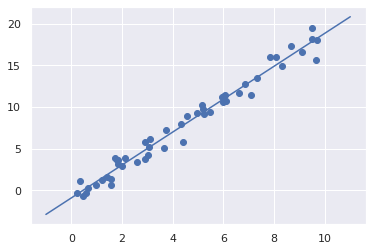

In [17]:
plt.scatter(x, y)
plt.plot(xfit, yfit)

### Наивный баесовский классификатор для ириса (обучение с учителем)

Предположим, что все распределения в датасете взяты из выровненного по осям координат гаусова распределения. Разделим данные на трейн/тест.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris, random_state=1)

In [20]:
# модель
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [21]:
model.fit(Xtrain, ytrain)

GaussianNB()

In [22]:
y_model = model.predict(Xtest)

In [23]:
# точность
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.9736842105263158

### Обучение без учителя (понижение размерности)

Используем PCA для ириса (там 4 признака, снизим до двух измеренеий)

In [24]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
model.fit(X_iris)
X_2D = model.transform(X_iris)

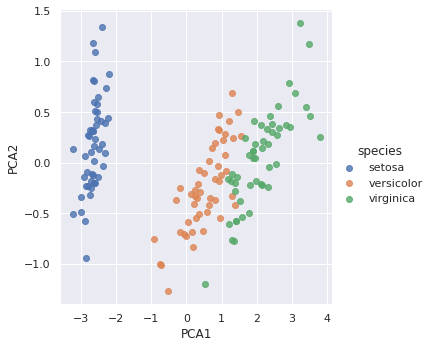

In [25]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.lmplot('PCA1', 'PCA2', hue='species', data=iris, fit_reg=False)

### Обучение без учителя (кластеризация)

Используем GMM (gausian mixture model)

In [26]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=3, covariance_type='full')

In [27]:
model.fit(X_iris)

GaussianMixture(n_components=3)

In [28]:
y_gmm = model.predict(X_iris)

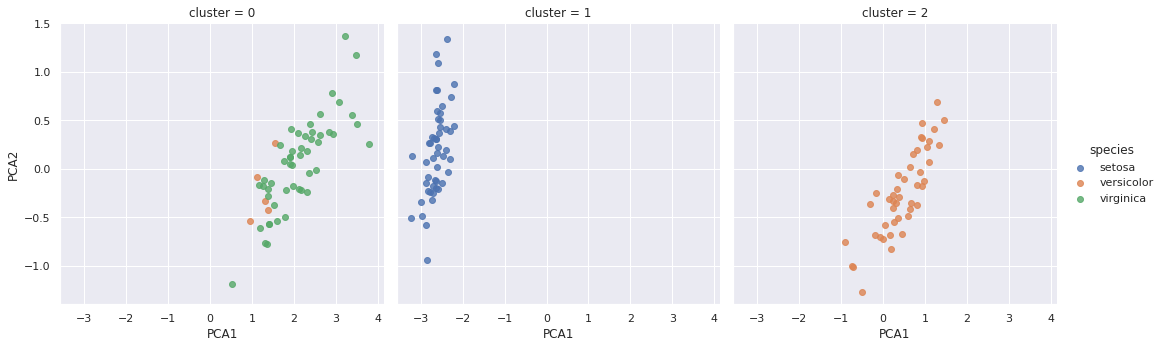

In [29]:
iris['cluster'] = y_gmm
sns.lmplot('PCA1', 'PCA2', hue='species', data=iris, col='cluster', fit_reg=False)

### Анализ рукописных цифр

In [30]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

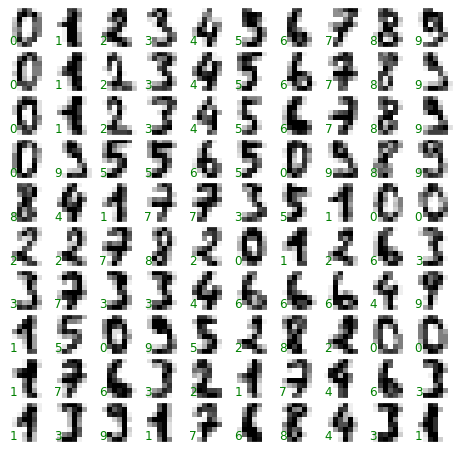

In [31]:
# визуализация первых 100 изображений
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                      subplot_kw={'xticks':[], 'yticks':[]},
                      gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary',
             interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
           transform=ax.transAxes, color='green')

Получим для изображения 8х8 вектор 64, где каждое значение - это пиксел в изображении. y - набор целей.

In [32]:
X = digits.data
X.shape

(1797, 64)

In [33]:
y = digits.target
y.shape

(1797,)

#### Понижение размерности

снизим 64-мерное пространство до двухмерного с помощью Isomap

In [34]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(X)
data_projected = iso.transform(X)
data_projected.shape

(1797, 2)

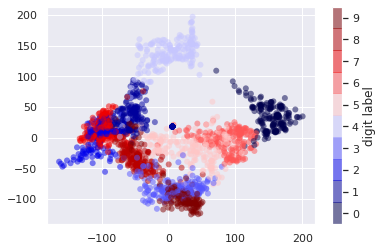

In [35]:
plt.scatter(data_projected[:, 0], data_projected[:, 1],
           c=y, edgecolor='none', alpha=0.5,
           cmap=plt.cm.get_cmap('seismic', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5)

#### классификация

используем туже наивную баесовскую модель, что и для ириса

In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [37]:
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

In [38]:
accuracy_score(ytest, y_model)

0.8333333333333334

Confusion matrix помогает понять где модель чаще всего ошибается

Text(89.18, 0.5, 'true')

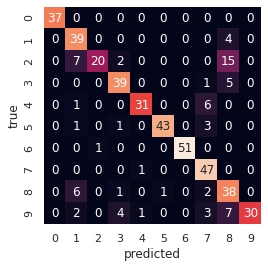

In [39]:
from sklearn.metrics import confusion_matrix
matr = confusion_matrix(ytest, y_model)
sns.heatmap(matr,square=True, annot=True, cbar=False)
plt.xlabel('predicted')
plt.ylabel('true')

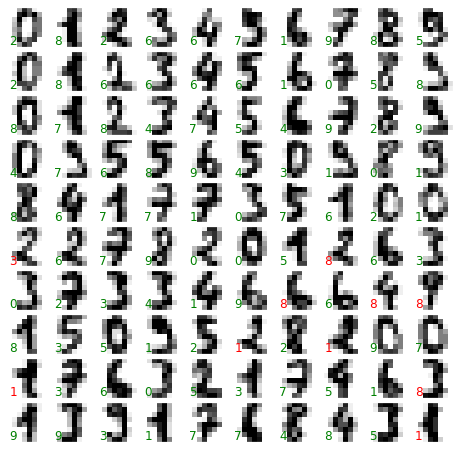

In [40]:
# можно вывести входные данные с предсказакныыми метками
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                      subplot_kw={'xticks':[], 'yticks':[]},
                      gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary',
             interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
           transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

### Проверка модели (validation curve)

будем использовать простую линейную регрессию с полиномиальным препроцессингом в пайплайне

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [42]:
def pol_reg(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [43]:
# создадим данные
def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rnd.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rnd.randn(N)
    
    return X, y

In [44]:
X, y = make_data(40)

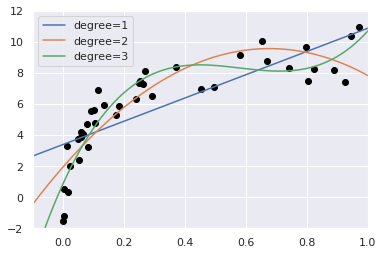

In [47]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 2, 3]:
    y_test = pol_reg(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best')

визуализируем кривую проверки с помощью validation_curve. Функция получает на вход модель, данные, назвение параметра и диапазон для анализа. Затем вычисляется значения для оценки эффективности модели.

In [48]:
from sklearn.model_selection import validation_curve


In [49]:
degree = np.arange(0, 21) # степень полинома
train_score, val_score = validation_curve(pol_reg(), X, y,
                                         'polynomialfeatures__degree',
                                         degree, cv=7)

/home/konstantin/anaconda3/envs/ml-base/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Text(0, 0.5, 'score')

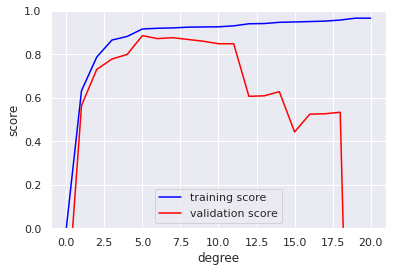

In [50]:
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')


(-0.04852459215955282,
 1.020079741966909,
 -2.1697496484420618,
 11.556426428423329)

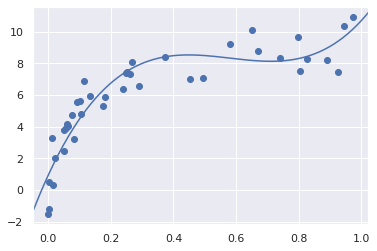

In [51]:
# оптимальный вариант - степень 5
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = pol_reg(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)

Поведение кривых проверки зависят от двух факторов:

- сложности модели
- количества точек обучения

Бывает важно исследовать поаедения модели от количества точек обучения. Это можно реализовать за счет постепенно увеличивающегося подмножества данных обучения.

### кривые обучения (learning curve)

это график оценок обучения/проверки с учетом размера обучающей выборки. Должен вести себя так:

- переобучение на слишком маленьком наборе данных
- недообучение на слишком большом наборе
- на проверке всегда хуже, чем при обучении

Если достигнута точка, при которой данная конкретная модель сошлась, то добавление новых обучающих данных уже ничего не даст.

/home/konstantin/anaconda3/envs/ml-base/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Text(0, 0.5, 'score')

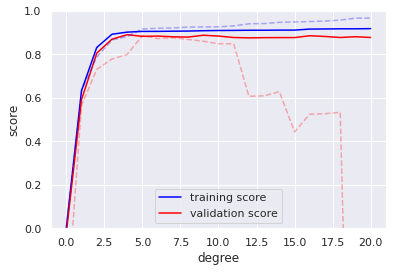

In [55]:
X2, y2 = make_data(200)
degree = np.arange(21)
train_score2, val_score2 = validation_curve(pol_reg(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

In [52]:
from sklearn.model_selection import learning_curve

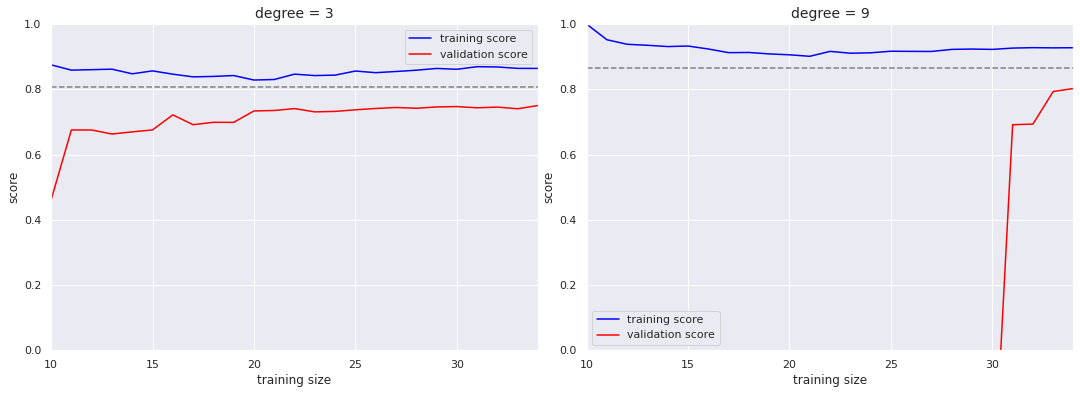

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([3, 9]):
    N, train_lc, val_lc = learning_curve(pol_reg(degree),
                                        X, y, cv=7,
                                        train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Добавление данных в простую модель не улучшает результат, т.к. модель быстро сошлась. Улучшить модель теперь можно только усложнив ее (т.е., в данном случае, увеличив степень). Однако бесконечно усложнаять модель не получится - переобучение.